# 25 - Debiased/Orthogonal Machine Learning
 
 
The next meta-learner we will consider actually came before they where even called meta-learners. The first article I can could find on it was Chernozhukov et al 2016, but then a buch of follow up papers came along (also by Chernozhukov and others) and this whole techique became a very widespread method for using ML in causal inferece.

![img](./data/img/debiased-ml/victor.png)

The thing that caught my attention about it is how well justified this aproach is. The other methods that we've seen so far, the T-learner, S-Learner and X-learner, all seem a bit hackish. We can give an intuitive explanation about why they work, but that didn't seem very general. In contrast, here with Debiased/Orthogonal Machine Learning, we have a general framework we can apply which is both very intuitive and also very rigorous. Another bonus is that Debiased/Orthogonal ML works for both continuous and discrete treatments, something that neither the T, not X learner could do. Not to mention that the papers describing it do an incredible job with the assynthotic analysis of this estimator. So without further ado, lets get down to it.  

Once again, we will resort to our ice cream sales dataset. Just as a reminder, here we are trying to find heterogeneity on the effect of price on sales. Our test set has randomly assigned prices but our training data has only observational prices, which is potentially biased. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf

In [2]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<AxesSubplot:xlabel='price', ylabel='sales'>

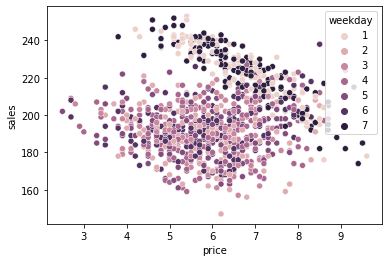

In [3]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

As we can see, prices are much higher on the weekend (weekday 1 and 7), but we can also have other confounders, like temperature and cost. 

## ML for Nuisance Parameters

Let's consider a linear model to estimate the treatment effect of prices on sales. 

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 cost_i + \pmb{\beta_3} Weekday_i + e_i
$$

where \\(\pmb{\beta_3}\\) is a vector of parameters associated to each weekday dummy. 

We are only interested in the \\(\tau\\) parameter because thats our treatment effect. We are going to call the other parameters nuisance parameters because we don't care about them. But, as it turns out, even if we don't care about them, we have to get them right, because if we don't, our treatment effect will be off. Thats anoying. 

For instance, if we think about it, the relationship between `temp` and sales is probably not linear. At first, as temperature increases, more people will go to the beach, so sales will increase. But, at some point, it becomes too hot and people decide it is best to stay home. At that point, sales will drop. The relationship between `temp` and sales probably peeks somewhere. Which means the above model is probably wrong. It should have been something like

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 cost_i + \pmb{\beta_4} Weekday_i + e_i
$$

with a quadratic terms. 

Thinking about how to model nuisance parameter is already boring with just a few covariates. But what if we had tens or hundreds of them? With modern datasets, this is pretty common to happen. So, what can we do about it? The answer is in the coolest Ecnometric theorem ever derived

### Frisch-Waugh-Lovell

Frisch, Waugh and Lovell where 19th century econometricias who noticed the coolest thing about linear regression. This isn't new to you, as we've talked about it in the context of regression residuals and when talking about fixed effects. But since this theorem is key to understanding Orthogonal-ML, its very much worth recaping it.

Suppose you have a linear regression model with a set of features \\(X_1\\) and another set of features \\(X_2\\).

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

where \\(X_1\\) and \\(X_1\\) are feature matrices (one row per feature and one column per observation) and \\(\hat{\beta_1}\\) and \\(\hat{\beta_2}\\) are row vectors. You can get the exact same \\(\hat{\beta_1}\\) parameter by doing the folowing steps

1. regress the outcome \\(y\\) on the second set of features \\(\hat{y^*} = \hat{\gamma_1} X_2\\)
2. regress the first set of features on the second \\(\hat{X_1} = \hat{\gamma_2} X_2\\)
3. obtain the residuals \\(\tilde{X}_1 = X_1 - \hat{X_1}\\) and \\(\tilde{y}_1 = y_1 - \hat{y^*}\\)
4. regress the residuals of the outcome on the residuals of the features \\(\hat{y} = \hat{\beta_1} \tilde{X}_1\\)

This is insanely cool. It means you can estimate all the nuicense parameters separatly. But don't take my word for it. In the example below, we estimate the treatment effect by first estimating the effects of the covariates on the outcome (sales) and treatment (price). Then, with the residuals, we estimate the ATE of price on sales.

In [4]:
import statsmodels.formula.api as smf

my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

smf.ols("sales_res~price_res", data=train.assign(sales_res=my.resid, price_res=mt.resid)).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.848e-13,0.111,-3.48e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


In [5]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475403

As you can see, they are the exact same number!

Aother way of saing this is that the treatment effect can be derived from **regression on residuals**, where we obtain the residuas from regressing \\(Y\\) on \\(X\\) and regress it on the residuals of regressing \\(T\\) on \\(X\\). Let's say that \\(\sim\\) is the regression operator, so we summarize FWL theorem as follows. 

$
(Y - (Y\sim X)) \sim (T - (T \sim X))
$

which is essentially estimating the causal parameter \\(\theta\\) in the folowing linear model

$
Y - E[Y | X]
= \theta \cdot (T - E[T | X]) + \epsilon
$

As I've said, FWL is so awsome because it allow us to separate the estimation procedure of the causal parameter from that of the nuicense parameters. But we still din't answer our initial question, wich is how can we avoid all the hassle from having to especify the correct functional form on the nuicence parameters? Or, in other words, how can a focus only on the causal parameter without having to worry about the nuicence parameters? Here is where machine learning comes to play. 

### Frisch-Waugh-Lovell on Steroids

Double/Debiased ML can be seen as Frisch, Waugh and Lovell theorem on steroids. The idea is very simple: use ML models when construction the outcome and treatment residuals. 

$
Y - \hat{M}_y[Y | X]
= \theta \cdot (T - \hat{M}_t[T | X]) + \epsilon
$

The idea is that ML models are super flexible, hence, they can capture interactions and non linearities when estimating the \\(Y\\) and \\(T\\) residuals in a FWL style orthogonalization. This means we don't have to make any parametric assumption about the relationship between the covariates \\(X\\) and the outcome \\(Y\\) in order to get the treatment effect. 

1. Estimate the outcome \\(Y\\) with features \\(X\\) using a flexible ML regression model M_y. 
2. Estimate the treatment \\(T\\) with features \\(X\\) using a flexible ML regression model M_t. 
3. Obtain the residuals \\(\tilde{Y} = Y - M_y(X)\\) and \\(\tilde{T} = T - M_t(X)\\)
4. regress the residuals of the outcome on the residuals of the treatment \\(\tilde{Y} = \alpha + \theta \tilde{T}\\)

where \\(\theta\\) is the causal parameter ATE.

The power you gain with ML is flexibility. It is so powerfull that can capture complicated functional forms in the nuiscance relationships. But that flexibility is also troublesome, because it means we now have to take into account the possibility of overfitting.

![img](./data/img/debiased-ml/ml-problem.png)

Chernozhukov et al (2016) has a much more in depth and rigurous explanation about how overfitting can be troublesome and I defenetly recomend you check it out. But here, I'll go on a more intuition base exmplanation. To see the issue, suppose that your \\(M_y\\) model is overfitting. The result is that the residual \\(\tilde{Y}\\) will be smaller than it should be. It also means that \\(M_y\\) is capturing more than only the relationship between \\(X\\) and \\(Y\\). Part of that something more is the relationship between \\(T\\) and \\(Y\\), and if \\(M_y\\) is capturing some of that, the residual regression will be biased twards zero. 

Now to see the problem in overfitting \\(M_t\\), notice that it will explain more of the variance in \\(T\\) than it should. As a result, the treatment residual will have less variance than in should. If there is less varriance in the treatment, the variance of the estimator will be high. It is as if the treatment is the same for almost everyone, making it very difficult to estimate what would hapend under different treatment regimes. As a side note, this will also happen when \\(T\\) is a deterministic function of \\(X\\), meaning positivity is being violated.

Those are the problems we have when using ML models, but how can we correct for them? The ansower lies in what we will call cross prediction.

![img](./data/img/debiased-ml/cross-prediction.png)

We will split out data into K parts of equal size. Then, for each part k, we will estimate the ML models on all the other K-k samples and make the residuals on the k part. Notice that this residuals are made with out of fold prediction, so even if the model does overfitt, it won't drive the residuals to zero artificially. Finally, we combine the predictions on all the K parts to estimate the final causal model \\(\tilde{Y} = \alpha + \theta \tilde{T}\\).

OK, we've coverd a lot of ground. To go along with all that theory, let's go through a step by step implementation of the Double/Debiased ML. As we do so, I'll take the oportunity to explain what each step is doing. 

First, lets estimate the nuicence relationship using ML models. I'll start with the treatment model \\(M_t\\). We will use a LGBM model to predict prices from the covariatse `temp`, `weekday` and `cost`. These predictions will be cross predictions, which we can get from using `sklearn`'s `cross_val_predict` function. I'm also adding \\(\hat{\mu_t}\\) to the residuals just for visualization purposes.

In [6]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

Notice that I'm caling the \\(M_t\\) model the debias model. That's because the role this model is playing on the Double/Debias ML is one of denoising the treatment. The residuals \\(\tilde{T} = T - M_t(X)\\) can be viwed as a version of the treatment where all the confounding bias from \\(X\\) has been removed by the model. In other words, \\(\tilde{T}\\) is orthognal to \\(X\\). Intuitivly, \\(\tilde{T}\\) can no longer be explained by \\(X\\), because it already was. 

To see that, we can show the same plot we've seen earlier by now replacing price with the price residuals. Remember that, before, weekends had higher prices? Now, that bias is gone. All the weekdays have the same price residual distribution. 

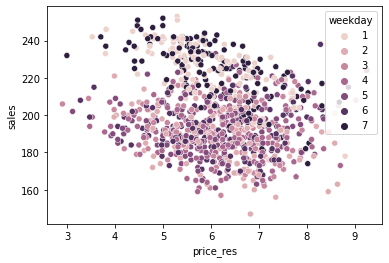

In [7]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

The role of \\(M_t\\) is to debias the treatment, but what about \\(M_y\\)? Its role is to remove the variance from \\(Y\\). Hence, I'll call it the denoising model. Intuitivly, \\(M_y\\) is creating a version of the outcome where all the variance due to \\(X\\) has been explained away. As a result, it becomes easier to do causal estimation in \\(\tilde{Y}\\). Since it has less noise, the causal relationship becomes easier to see. 

In [8]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

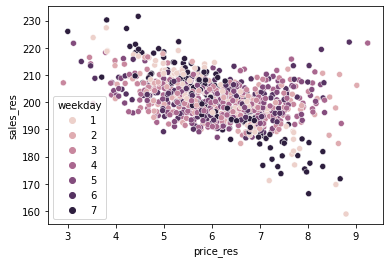

In [9]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

If we plot the same graph as before, but now replacing sales with sales residual, we can see that the variance in \\(Y\\) is much smaller than it was before. It is now easy to see the negative relationship between prices and sales. 

Finally, to estimate that causal relationship, we can run a regression on the residuals.

In [10]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


As we can see, when we uses the residualized or orthogonalized version of sales and price, we can be very confident that the relationship between prices and sales is negative, which makes a lot of sense. As we increase prices, demand for icecream should fall.

But if we look at the un-residualized or raw relationship between prices and sales, because of bias, we find a positive relationship.

In [11]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


So far, we've seen how Double/Debiased ML allow us to focus on estimate the Average Treatment Effect (ATE), but it can also be used for treatment effect heterogeneity, or CATE estimation. We will use the same residualized version of price and sales and interacti price with the other covariates. Then, we can fit a linear CATE model.

To make CATE predictions, we will use the randomized test set. Since this final model is linear, we can compute the CATE macanically by

$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

In [12]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

To check how good is this model in terms of diferentiating units with high price sensitivity from those with low price sensitivity, we will use the cumulative elasticity curve. 

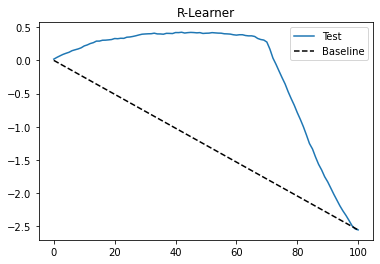

In [13]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

Double/Debiased ML procedure with a final linear model in the is already very good. But, maybe we can do even better. As a matter of fact, this is a very general procedure that we frame it just like a meta-learner. Nie and Wager called it the R-Learner, as a way to recognise the work of Donald Rubin in the causal literature.

This generalization comes from realizing that the Double/Debiased ML procedure defines a new loss function that we can minimize however we want. Next, we will see how to do that in a very similar fashion to what we've done before when discussing target tranformation. 

## Non Parametric Double/Debiased ML

The nice thing about Double-ML is that it frees us all the hassle of learning the nuiscence parameters in a causal model. With that, we can focus all our atention at learning the causal parameter of interest, be it the ATE of the CATE. However, with the above specification, we where still using a linear model after the ML residualization, as the final causal model. Which means we are assuming prices impact sales linearly. Thats probably OK for a small range of prices, but we know from microeconomic theory that thats not necessarly the case. It could be that, at low prices, a unit increse in price will lower demand by 2 units. But then, at higher prices, a unit increase in price will lower demand by just 1 unit. Thats not a linear relationship.

We could leverage microeconomic theory here to speculate about the functional from of the outcome on the treatment, but maybe we can also delegate that to a ML model. As it turns out, thats totally possible if we make just a few changes to our original Double/Debiased ML algorithm.

First, we start exacly as before, orthogonalising the treatment and the outcome with cross predictions from a ML model.

In [14]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

Now is where things get interesting. Recall that Double/Debiased-ML models the data as follows

$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$

Where \\(\hat{M}_y\\) and \\(\hat{M}_t\\) are models that, respectivly, predicts the outcome and treatment from the features. If we rearange the terms above, we can isolate the error term

$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$

This is nothing short of awsome, because now we can call this a **causal loss function**. Which means that, if we minimize the square of this loss, we will be estimating \\(\tau(X_i)\\), which is the CATE.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$

This loss is also called the **R-Loss**, since it's what the R-learner minimizes. Ok, but how do we minimize this loss function? There are multiple ways, actually, but here we will cover the simplest one. First, to decluder the tecnical notation, lets define the residuals

$
\tilde{T}_i = T_i - \hat{M}_t(X)
$

and 

$
\tilde{Y}_i = Y_i - \hat{M}_y(X)
$

Now, lets rewrite the loss function we had before. 

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$

Finally, we can to some algebric parkour to take \\(\tilde{T}_i\\) out of the parenthesis and isolate \\(\tau(X_i)\\) in the loss function.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2 
$$

Minimizing the above loss is equivalent to minimizing what is inside the parenthesis, but weighting each tem by \\(\tilde{T}_i^2\\). Minimizing that is inside the parenthesis is equivalent to predicting \\(\frac{\tilde{Y}_i}{\tilde{T}_i}\\). This is what's called the weight trick to get the non-parametric causal loss. Notice how similar this is to the target tranformation idea we saw earlies. This is, indeed, a target tranformation, but with the extra weighting trick.

To summarise before we go to the code, now that we have the nuiscence models, we will
1. Create weights \\(\tilde{T}_i^2\\)
2. Create a target \\(\frac{\tilde{Y}_i}{\tilde{T}_i}\\)
3. Use any prediction method to predict the above target with the above weights. 

And here is the code. As you will see, it is incredibly simple.

In [15]:
model_final = LGBMRegressor(max_depth=3)

# create the weights
w = train_pred["price_res"] ** 2 

# create the tranformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])

# use a weigthed regression ML model to predict the target with the weghts.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

The above ML model, even though it is a off-the-shelf predictive model, is estimating the CATE. That's the power of the non-parametric Double-ML. Before, we where using a linear regression as the final model the the CATE estimation. Now, since we defined a generic loss, we can use any predictive model at our disposal as the final model to estimate the CATE. 

Let's now use the test set to compare this non-parametric version with the linear version we had before. First, we estimate the individual treatment effect.

In [16]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

Next, we can plot the non-parametric cumulative elasticity curve side by side with the one we got from the parametric  (linear) version of Double-ML.

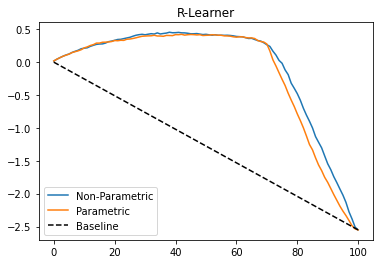

In [17]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");



### What is the



## Non Scientific Double/Debiased ML

In [18]:
from sklearn.model_selection import KFold

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

In [19]:
def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)
    m = model(**model_params)
    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

In [20]:
model_final = LGBMRegressor(max_depth=3)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

In [21]:
pred_test = (test
             .drop(columns=["price"])
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"])
            )

pred_test.query("index==0")

,index,temp,weekday,cost,sales,price
0,0,25.8,1,0.3,230,3.000
1,0,25.8,1,0.3,230,3.875
2,0,25.8,1,0.3,230,4.750
3,0,25.8,1,0.3,230,5.625
4,0,25.8,1,0.3,230,6.500
5,0,25.8,1,0.3,230,7.375
6,0,25.8,1,0.3,230,8.250
7,0,25.8,1,0.3,230,9.125
8,0,25.8,1,0.3,230,10.000


In [22]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

y_hat_test = ensamble_pred(pred_test, models_y, X)
t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

In [23]:
pred_test.query("index==0")

,index,temp,weekday,cost,sales,price,sales_pred
0,0,25.8,1,0.3,230,3.000,255.597143
1,0,25.8,1,0.3,230,3.875,251.905580
2,0,25.8,1,0.3,230,4.750,245.492803
3,0,25.8,1,0.3,230,5.625,237.142461
4,0,25.8,1,0.3,230,6.500,229.158320
5,0,25.8,1,0.3,230,7.375,219.148637
6,0,25.8,1,0.3,230,8.250,209.270283
7,0,25.8,1,0.3,230,9.125,207.454138
8,0,25.8,1,0.3,230,10.000,207.454138


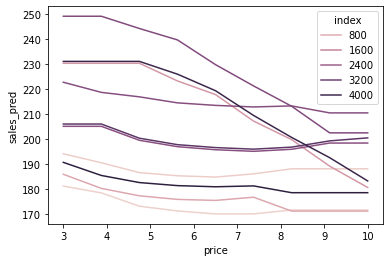

In [24]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

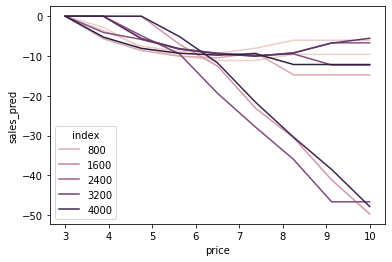

In [25]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"])),
             x="price", y="sales_pred", hue="index");